In [1]:
# hide
# default_exp model_fitting

from nbdev.showdoc import *

# InstanceCMR Benchmark

## Configuring the Parameter Search
To fit the model to some dataset, we select a cost function that scales against the likelihood that the model with a specified parameter configuration could have generated the specified dataset. Since our fitting functions are optimized on a per model basis, we need a unique one for InstanceCMR and this dataset.

In [2]:
# export
# hide

import numpy as np
from numba import njit
from numba.typed import List
from instance_cmr.models import InstanceCMR


@njit(fastmath=True, nogil=True)
def icmr_murd_likelihood(data_to_fit, item_counts, encoding_drift_rate, 
                    start_drift_rate, recall_drift_rate, shared_support, 
                    item_support, learning_rate, primacy_scale, primacy_decay, 
                    stop_probability_scale, stop_probability_growth, 
                    choice_sensitivity, context_sensitivity, feature_sensitivity):
    """
    Generalized cost function for fitting the InstanceCMR model optimized 
    using the numba library.
    
    Output scales inversely with the likelihood that the model and specified 
    parameters would generate the specified trials. For model fitting, is 
    usually wrapped in another function that fixes and frees parameters for 
    optimization.

    **Arguments**:
    - data_to_fit: typed list of int64-arrays where rows identify a unique 
        trial of responses and columns corresponds to a unique recall index.  
    - A configuration for each parameter of `InstanceCMR` as delineated in 
        `Formal Specification`.

    **Returns** the negative sum of log-likelihoods across specified trials 
    conditional on the specified parameters and the mechanisms of InstanceCMR.
    """
        
    result = 0.0
    for i in range(len(item_counts)):
        item_count = item_counts[i]
        trials = data_to_fit[i]
        
        model = InstanceCMR(item_count, item_count, encoding_drift_rate, 
                          start_drift_rate, recall_drift_rate, shared_support, 
                          item_support, learning_rate, primacy_scale, 
                          primacy_decay, stop_probability_scale, 
                          stop_probability_growth, choice_sensitivity,
                           context_sensitivity, feature_sensitivity)

        model.experience(np.eye(item_count, item_count + 1, 1))

        likelihood = np.ones((len(trials), item_count))

        for trial_index in range(len(trials)):
            trial = trials[trial_index]

            model.force_recall()
            for recall_index in range(len(trial) + 1):

                # identify index of item recalled; if zero then recall is over
                if recall_index == len(trial) and len(trial) < item_count:
                    recall = 0
                else:
                    recall = trial[recall_index]

                # store probability of and simulate recalling item w this index
                activation_cue = np.hstack(
                    (np.zeros(model.item_count + 1), model.context))
                likelihood[trial_index, recall_index] = \
                    model.outcome_probabilities(activation_cue)[recall]

                if recall == 0:
                    break
                model.force_recall(recall)

            # reset model to its pre-retrieval (but post-encoding) state
            model.force_recall(0)
        result -= np.sum(np.log(likelihood))
        
    return result

In [3]:
# export
# hide

def icmr_murd_objective_function(data_to_fit, fixed_parameters, free_parameters):
    """
    Generates and returns an objective function for input to support search 
    through parameter space for ICMR model fit using an optimization function.

    Arguments:  
    - fixed_parameters: dictionary mapping parameter names to values they'll 
        be fixed to during search, overloaded by free_parameters if overlap  
    - free_parameters: list of strings naming parameters for fit during search  
    - data_to_fit: array where rows identify a unique trial of responses and 
        columns corresponds to a unique recall index

    Returns a function that accepts a vector x specifying arbitrary values for 
    free parameters and returns evaluation of icmr_likelihood using the model 
    class, all parameters, and provided data.
    """
    
    return lambda x: icmr_murd_likelihood(data_to_fit, **{**fixed_parameters, **{
        free_parameters[i]:x[i] for i in range(len(x))}})

In [4]:
try:
    show_doc(icmr_murd_likelihood, title_level=3)
    show_doc(icmr_murd_objective_function, title_level=3)
except:
    pass

<h3 id="icmr_murd_likelihood" class="doc_header"><code>icmr_murd_likelihood</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h3>

> <code>icmr_murd_likelihood</code>(**`data_to_fit`**, **`item_counts`**, **`encoding_drift_rate`**, **`start_drift_rate`**, **`recall_drift_rate`**, **`shared_support`**, **`item_support`**, **`learning_rate`**, **`primacy_scale`**, **`primacy_decay`**, **`stop_probability_scale`**, **`stop_probability_growth`**, **`choice_sensitivity`**, **`context_sensitivity`**, **`feature_sensitivity`**)

Generalized cost function for fitting the InstanceCMR model optimized 
using the numba library.

Output scales inversely with the likelihood that the model and specified 
parameters would generate the specified trials. For model fitting, is 
usually wrapped in another function that fixes and frees parameters for 
optimization.

**Arguments**:
- data_to_fit: typed list of int64-arrays where rows identify a unique 
    trial of responses and columns corresponds to a unique recall index.  
- A configuration for each parameter of [`InstanceCMR`](/instance_cmr/InstanceCMR.html#InstanceCMR) as delineated in 
    `Formal Specification`.

**Returns** the negative sum of log-likelihoods across specified trials 
conditional on the specified parameters and the mechanisms of InstanceCMR.

<h3 id="icmr_murd_objective_function" class="doc_header"><code>icmr_murd_objective_function</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h3>

> <code>icmr_murd_objective_function</code>(**`data_to_fit`**, **`fixed_parameters`**, **`free_parameters`**)

Generates and returns an objective function for input to support search 
through parameter space for ICMR model fit using an optimization function.

Arguments:  
- fixed_parameters: dictionary mapping parameter names to values they'll 
    be fixed to during search, overloaded by free_parameters if overlap  
- free_parameters: list of strings naming parameters for fit during search  
- data_to_fit: array where rows identify a unique trial of responses and 
    columns corresponds to a unique recall index

Returns a function that accepts a vector x specifying arbitrary values for 
free parameters and returns evaluation of icmr_likelihood using the model 
class, all parameters, and provided data.

## Single-Subject Demo

Using these functions, we'll search for and visualize a parameter fit of the InstanceCMR model to a slice of data sampled from the classic Murdock (1962) study demonstrating the serial position curve, a pattern where early and later presented items tend to be recalled more often than middle items in a list-learning experiment. The data associated with the study is located at `data/MurdData_clean.mat`.

In [5]:
from instance_cmr.datasets import *

murd_trials0, murd_events0, murd_length0 = prepare_murddata(
    '../../../data/MurdData_clean.mat', 0)
print(murd_length0, np.shape(murd_trials0))

murd_events0.head()

20 (1200, 15)


,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,5.0,True,True,0,False
1,1,1,2,2,7.0,True,True,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


First, we'll make sure `cmr_murd_likelihood` returns valid values and has adequate performance.

In [6]:
lb = np.finfo(float).eps
hand_fit_parameters = {
    'item_counts': List([murd_length0]),
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2,
    'context_sensitivity': 1,
    'feature_sensitivity': 1
}
icmr_murd_likelihood(List([murd_trials0[:80]]), **hand_fit_parameters)

1543.9470532219602

In [7]:
%%timeit
icmr_murd_likelihood(List([murd_trials0[:80]]), **hand_fit_parameters)

9.46 ms ± 47.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now we perform the single subject fitting...

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'context_sensitivity',
    'feature_sensitivity']

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, 10),
    (lb, 10)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = icmr_murd_objective_function(
    List([murd_trials0[:80]]), 
    {'item_counts': List([murd_length0])}, free_parameters)

result = differential_evolution(cost_function, bounds, disp=True)
print(result)

For the first subject in our murd_trials data structure, the function runs quickly returns an output with the following attributes:

```
     fun: 1414.3462017866646
     jac: array([ 1.92703736e+00,  1.28559668e+02, -1.75441527e+00, -5.56749001e+01,
       -2.09183780e-01,  6.23202936e+03, -7.00674660e-01,  0.00000000e+00,
        6.03609578e+01,  7.56240297e+00, -2.66209101e-01, -2.35268090e+00,
       -7.20638127e-01])
 message: 'Optimization terminated successfully.'
    nfev: 16524
     nit: 65
 success: True
       x: array([7.81056951e-01, 2.22044605e-16, 8.35958058e-01, 3.27842091e-03,
       1.00000000e+00, 6.06888398e-06, 1.33915473e+01, 8.06231229e+01,
       1.15714873e-02, 3.93138394e-01, 4.57500643e+00, 1.90263326e-01,
       3.14200355e-01])
```

The `x` attribute of the result object contains the best parameter configuration found, while the `fun` attribute represents the overall cost of the configuration as computed with our specified cost function. 

We can visually compare the behavior of the model with these parameters against the data it's fitted to with our `visualize_fit` function.

In [10]:
from instance_cmr.model_fitting import visualize_fit

show_doc(visualize_fit)

<h4 id="visualize_fit" class="doc_header"><code>visualize_fit</code><a href="https://github.com/vucml/instance_cmr/tree/master/instance_cmr/model_fitting.py#L97" class="source_link" style="float:right">[source]</a></h4>

> <code>visualize_fit</code>(**`model_class`**, **`parameters`**, **`data`**, **`data_query`**=*`None`*, **`experiment_count`**=*`1000`*, **`savefig`**=*`False`*)

Apply organizational analyses to visually compare the behavior of the model
with these parameters against specified dataset.

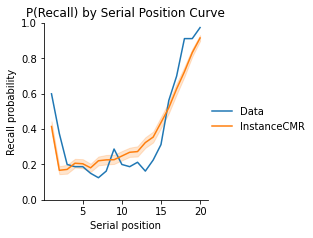

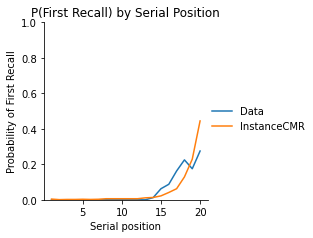

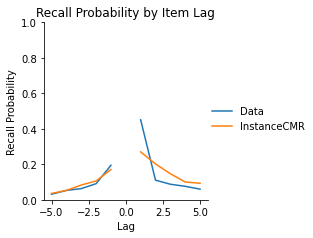

In [11]:


parameters = {
    'item_count':murd_length0,
    'presentation_count': murd_length0
}

visualize_fit(InstanceCMR, 
              {**parameters, 
               **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
              murd_events0, 'subject == 1', experiment_count=1000, savefig=True)